In [1]:
!pip install deap matplotlib tqdm

Instalar a diblioteca DEAP

pip install deap

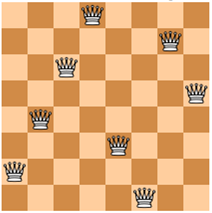

## Cromossomo

### Binário:
[001 011 101 111 010 110 100]

### Real:
[1 3 5 7 2 0 6 4]


In [2]:
import numpy as np
import random
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
#N = Número de rainhas
N = 8
#log_N = número de bits para representar cada rainha
log_N = int(np.log2(N))


#Funções extraídas do código original do livro
#https://github.com/aimacode/aima-python
def conflicted(state, row, col):
    """Would placing a queen at (row, col) conflict with anything?"""
    return any(conflict(row, col, state[c], c)
               for c in range(col))

def conflict(row1, col1, row2, col2):
    """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
    return (row1 == row2 or  # same row
            col1 == col2 or  # same column
            row1 - col1 == row2 - col2 or  # same \ diagonal
            row1 + col1 == row2 + col2)  # same / diagonal

def goal_test(state):
    """Check if all columns filled, no conflicts."""
    if state[-1] == -1:
        return False
    return not any(conflicted(state, state[col], col)
                   for col in range(len(state)))

def h(node):
    """Return number of conflicting queens for a given node"""
    num_conflicts = 0
    for (r1, c1) in enumerate(node):
        for (r2, c2) in enumerate(node):
            if (r1, c1) != (r2, c2):
                num_conflicts += conflict(r1, c1, r2, c2)
    return num_conflicts

def nqueen_fitness(node):
    node_int = []
    for i in range(0, len(node), log_N):
        a = map(str, node[i:i+log_N])    
        node_int.append(int(''.join(a), 2))

    return h(node_int),
    
def plot_solution(solution, N):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, N))
    ax.set_ylim((0, N))

    count = 0
    for queen in solution:
        ax.add_patch(patches.Rectangle((queen, count), 1, 1))
        count += 1
    plt.show()

In [4]:
goal_test([2,4,6,8,3,1,7,4])

False

In [5]:
h([2,2,6,7,3,1,7,4])

8

In [6]:
#Cria ferramenta de geração de indivíduos
creator.create("Fitness", base.Fitness, weights=(-1.0, )) #Peso -1 por ser um problema de minimização
#Cada indíviduo é composto por um cromossomo que é uma lista de valores
creator.create("Individual", list, fitness=creator.Fitness)

In [7]:
#Toolbox é onde definiremos os operadores para a execução
toolbox = base.Toolbox()

#Função para criação do cromossomo
#x = 0|1
toolbox.register("attr_bool", random.randint, 0, 1) #np.random.randint(0,1)
#Função para Definir a criação do indivíduo. Será feita a repetição da função attr_bool por n vezes
#cromossomo = [x, x, x, x, ..., x]     len(cromossomo) = n
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N*log_N)
#Função para criar população. Repetição de indivíduos para formar uma lista
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
#função de avaliação
toolbox.register("evaluate", nqueen_fitness)
#função de cruzamento
toolbox.register("mate", tools.cxOnePoint)
#função de mutação
#indpb probabilidade de mutação em bit
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
#função de seleção
toolbox.register("select", tools.selTournament, tournsize=11)

Operadores do framework DEAP

https://deap.readthedocs.io/en/master/api/tools.html

In [9]:
population = toolbox.population(n=1)

In [10]:
len(population[0])

24

In [11]:
nqueen_fitness(population[0])

(12,)

In [12]:
from tqdm import tqdm
#Inicia população con n indivíduos
population = toolbox.population(n=500)

#Número máximo de gerações
NGEN=50

#Avalia todos os indivíduos
fits = toolbox.map(toolbox.evaluate, population)
for fit, ind in zip(fits, population):
    ind.fitness.values = fit
    
    
avg = []
tops = []
worsts = []

for gen in tqdm(range(NGEN)):
    #Faz seleção
    population = toolbox.select(population, k=len(population))
    #Faz o cruzamento e mutação
    #cxpb = probabilidade de cruzamento
    #mutpb = probabilidade de mutação
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.05)
    
    #Reavalia
    avg_h = 0
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        avg_h += fit[0]
        ind.fitness.values = fit
        
    #nova população
    population[:] = offspring
        
    #pega melhor e pior indivíduos para montar o gráfico
    top = tools.selBest(population, k=1)
    worst = tools.selWorst(population, k=1)
    
    avg_h = avg_h/len(population)
    top_h = nqueen_fitness(top[0])[0]
    worst_h = nqueen_fitness(worst[0])[0]

    avg.append(avg_h)
    tops.append(top_h)
    worsts.append(worst_h)
    
    
    #Avalia critério de parada
    if(nqueen_fitness(top[0])[0] == 0): break
        
print('Melhor individuo:', nqueen_fitness(top[0]))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 16.91it/s]

Melhor individuo: (2,)


In [13]:
print('Melhor individuo:', nqueen_fitness(top[0]))

Melhor individuo: (2,)


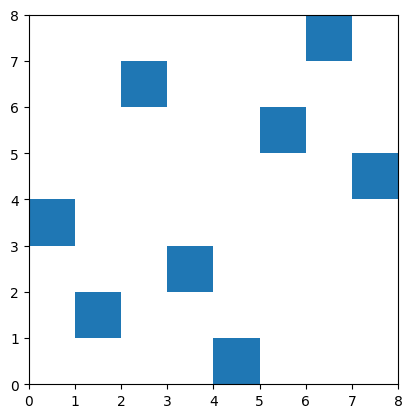

In [14]:
node_int = []
for i in range(0, len(top[0]), log_N):
    a = map(str, top[0][i:i+log_N])    
    node_int.append(int(''.join(a), 2))
    
plot_solution(node_int, N)

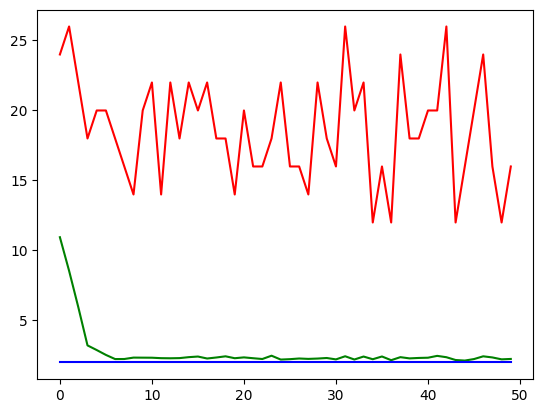

In [15]:
plt.plot(avg, c='g')
plt.plot(tops, c='b')
plt.plot(worsts, c='r')
plt.show()